# 06 – Model Evaluation

This notebook compares the performance of the trained models using various metrics and visualises the results with confusion matrices and ROC curves.


X_test shape: (40036, 14032)
y_test distribution:
0    0.950944
1    0.049056
Name: proportion, dtype: float64

Final Evaluation Results:
                Model  Accuracy        F1   ROC_AUC    PR_AUC
0  LogisticRegression  0.576456  0.098847  0.537782  0.056016
4              Voting  0.924093  0.036767  0.532063  0.053293
5            Stacking  0.921021  0.037150  0.516240  0.052612
1        RandomForest  0.923219  0.033941  0.514694  0.051916
2    GradientBoosting  0.886477  0.064622  0.501899  0.051421
3             XGBoost  0.934134  0.028729  0.497844  0.048930


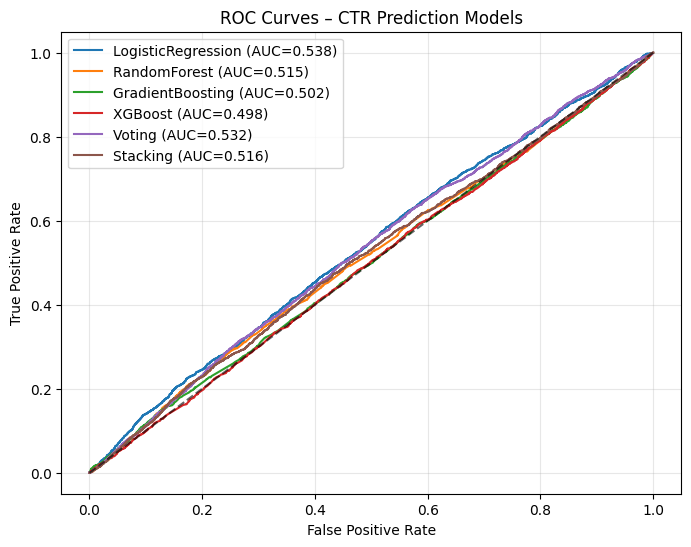

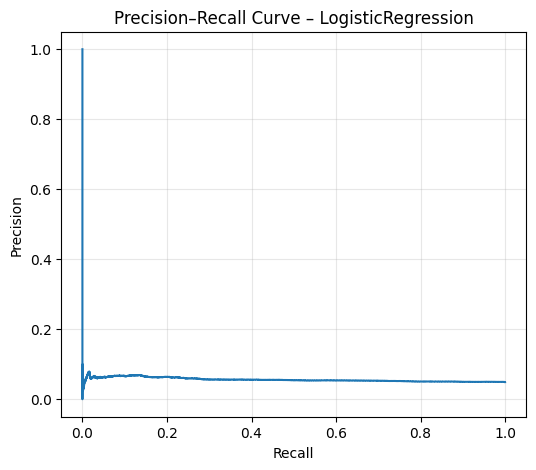

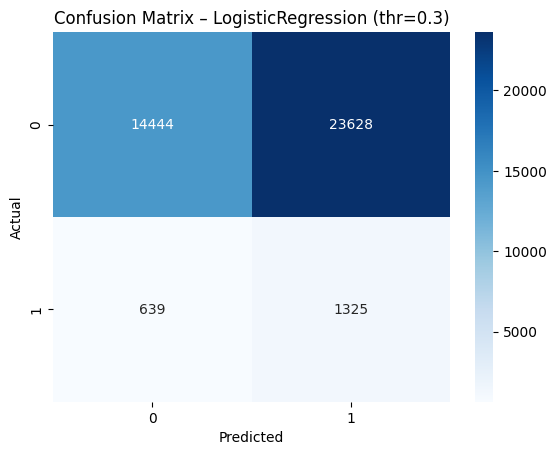

In [4]:
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.sparse import load_npz
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score,
    confusion_matrix
)

# ===============================
# Paths
# ===============================
project_root = r"d:\projects\Ai\project_fusion_ecu"
processed_dir = os.path.join(project_root, "data", "processed")
models_dir = os.path.join(project_root, "models")

X_test_path = os.path.join(processed_dir, "X_test_transformed.npz")
y_test_path = os.path.join(processed_dir, "y_test.csv")

if not os.path.exists(X_test_path):
    raise FileNotFoundError(X_test_path)
if not os.path.exists(y_test_path):
    raise FileNotFoundError(y_test_path)

# ===============================
# Load data
# ===============================
X_test = load_npz(X_test_path)
y_test = pd.read_csv(y_test_path).squeeze().values

print("X_test shape:", X_test.shape)
print("y_test distribution:")
print(pd.Series(y_test).value_counts(normalize=True))

# ===============================
# Load models
# ===============================
model_names = [
    "LogisticRegression",
    "RandomForest",
    "GradientBoosting",
    "XGBoost",
    "Voting",
    "Stacking"
]

results = []
roc_curves = []

for name in model_names:
    model_path = os.path.join(models_dir, f"{name}_model.pkl")
    if not os.path.exists(model_path):
        print(f"Skipping {name} (model not found)")
        continue

    model = joblib.load(model_path)

    preds = model.predict(X_test)
    probas = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, preds)
    f1  = f1_score(y_test, preds, zero_division=0)
    auc = roc_auc_score(y_test, probas)
    pr  = average_precision_score(y_test, probas)

    results.append([name, acc, f1, auc, pr])

    fpr, tpr, _ = roc_curve(y_test, probas)
    roc_curves.append((name, fpr, tpr, auc))

# ===============================
# Results table
# ===============================
results_df = pd.DataFrame(
    results,
    columns=["Model", "Accuracy", "F1", "ROC_AUC", "PR_AUC"]
).sort_values("PR_AUC", ascending=False)

print("\nFinal Evaluation Results:")
print(results_df)

# ===============================
# ROC Curves
# ===============================
plt.figure(figsize=(8, 6))
for name, fpr, tpr, auc in roc_curves:
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")

plt.plot([0, 1], [0, 1], "k--", alpha=0.6)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves – CTR Prediction Models")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# ===============================
# Precision–Recall Curve (Best Model)
# ===============================
best_model_name = results_df.iloc[0]["Model"]
best_model = joblib.load(os.path.join(models_dir, f"{best_model_name}_model.pkl"))

best_probas = best_model.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, best_probas)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision–Recall Curve – {best_model_name}")
plt.grid(alpha=0.3)
plt.show()

# ===============================
# Confusion Matrix (threshold tuned)
# ===============================
threshold = 0.3
best_preds = (best_probas >= threshold).astype(int)

cm = confusion_matrix(y_test, best_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix – {best_model_name} (thr={threshold})")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
